# Upload the Dataset

* In the colab, open the `Files` tab on the left pane.
* Drag and drop the `dataset.json` in the root directory.

In [232]:
! wget https://www.dropbox.com/s/npm6q6keqvmfo01/dataset_aueb_structure_v2.json

--2021-09-01 07:51:51--  https://www.dropbox.com/s/npm6q6keqvmfo01/dataset_aueb_structure_v2.json
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/npm6q6keqvmfo01/dataset_aueb_structure_v2.json [following]
--2021-09-01 07:51:51--  https://www.dropbox.com/s/raw/npm6q6keqvmfo01/dataset_aueb_structure_v2.json
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7c89bc596e34efb3f703aa40ca.dl.dropboxusercontent.com/cd/0/inline/BVVwfaffK6mgTrphDQLbcfB3X7AYgmbp3aQxmhmeVHIdTylwb6imGP6wBZxiKGeRJkfht-4RnM549fFxtPtHV2mawNTo4VvRwCoOpCw6H6ddDXQRemEyFu3ZKalvPbsCwVZyjSMDjnToif5V8QeTNUku/file# [following]
--2021-09-01 07:51:52--  https://uc7c89bc596e34efb3f703aa40ca.dl.dropboxusercontent.com/cd/0/inline/BVVwfaffK6mgTrphDQLbcfB3X7AYgmbp3aQ

# Load Dataset

The resulting dataset has one abstract per row. The sentences and the labels are list items.

In [233]:
import json
import pandas as pd

label2id = {
    'NONE': 0,
    'EVIDENCE': 1,
    'CLAIM': 2}

def load_corpus(path, label_mapping=None):
    with open(path) as fp:
        corpus = json.load(fp)

    documents, texts, labels = [], [], []
    for abstract in corpus:
        documents.append(abstract)
        texts.append(corpus[abstract]['sentences'])
        if isinstance(label_mapping, dict):
            labels.append(
                [label_mapping[str(l).upper()]
                    for l in corpus[abstract]['labels']])
        else:
            labels.append([str(l).upper() for l in corpus[abstract]['labels']])

    assert len(texts) == len(labels)
    data = pd.DataFrame(
        zip(documents, texts, labels),
        columns=['document', 'sentences', 'labels'])

    return data

data = load_corpus('dataset_aueb_argument_v3.json') #, label_mapping=label2id)
print(f'Dataset length: {len(data)} abstracts')
data.sample(5)

Dataset length: 1017 abstracts


,document,sentences,labels
163,doi: 10.1016/j.cub.2017.04.023,[APC/C Cdh1 Enables Removal of Shugoshin-2 fro...,"[NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ..."
857,doi: 10.1371/journal.pone.0221330,[Nasal sprayed particle deposition in a human ...,"[NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ..."
372,doi: 10.1029/2019ms001791,"[Evaluation of CNRM Earth System Model, CNRM‐E...","[NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ..."
351,doi: 10.1029/2018gl080384,[Contrasting Mechanical and Hydraulic Properti...,"[NEITHER, NEITHER]"
71,doi: 10.1007/978-1-4939-7465-8_19,[Computational Methods Used in Hit-to-Lead and...,"[NEITHER, NEITHER, NEITHER, NEITHER, NEITHER]"


## Split Documents
For the cases we want the sentences separated, the following splits the documents. I keep the same document index in a new column in order to re-group the sentences to a document (e.g., after predictions).

In [234]:
#@title Split to sentences
sentences = data['sentences'].explode().reset_index().rename(
    columns={'index': 'doc_id', 'sentences': 'sentence'})
sentences


,doc_id,sentence
0,0,Concordance Between Different Amyloid Immunoas...
1,0,Importance Visual assessment of amyloid positr...
2,0,Several immunoassays have been developed to me...
3,0,The agreement between CSF Aβ42 measures from d...
4,0,Objective To determine the concordance between...
...,...,...
10570,1016,"Instead, SBPs sample a range of conformations ..."
10571,1016,Certain non-transported ligands leave the stru...
10572,1016,"Intriguingly, in some cases, similar SBP confo..."
10573,1016,"In this case, the inability for transport aris..."


In [235]:
#@title and the corresponding labels
labels = data['labels'].explode().reset_index().rename(
    columns={'index': 'doc_id', 'labels': 'label'})
labels

,doc_id,label
0,0,NEITHER
1,0,NEITHER
2,0,NEITHER
3,0,NEITHER
4,0,NEITHER
...,...,...
10570,1016,NEITHER
10571,1016,NEITHER
10572,1016,NEITHER
10573,1016,NEITHER


In [236]:
#@title Regroup document using doc_id
doc0_sents = sentences.query('doc_id==0')['sentence']
doc0_labels = labels.query('doc_id==0')['label']
for label, sent in zip(doc0_labels, doc0_sents):
    print(f'{str(label):10s} {sent}')

NEITHER    Concordance Between Different Amyloid Immunoassays and Visual Amyloid Positron Emission Tomographic Assessment
NEITHER    Importance Visual assessment of amyloid positron emission tomographic (PET) images has been approved by regulatory authorities for clinical use.
NEITHER    Several immunoassays have been developed to measure β-amyloid (Aβ) 42 in cerebrospinal fluid (CSF).
NEITHER    The agreement between CSF Aβ42 measures from different immunoassays and visual PET readings may influence the use of CSF biomarkers and/or amyloid PET assessment in clinical practice and trials.
NEITHER    Objective To determine the concordance between CSF Aβ42 levels measured using 5 different immunoassays and visual amyloid PET analysis.
NEITHER    Design, Setting, and Participants The study included 262 patients with mild cognitive impairment or subjective cognitive decline from the Swedish BioFINDER (Biomarkers for Identifying Neurodegenerative Disorders Early and Reliably) cohort (recruit

In [237]:
#@title Combine each sentence with the correspoding label
df = pd.concat([sentences,labels['label']],axis=1)
df

,doc_id,sentence,label
0,0,Concordance Between Different Amyloid Immunoas...,NEITHER
1,0,Importance Visual assessment of amyloid positr...,NEITHER
2,0,Several immunoassays have been developed to me...,NEITHER
3,0,The agreement between CSF Aβ42 measures from d...,NEITHER
4,0,Objective To determine the concordance between...,NEITHER
...,...,...,...
10570,1016,"Instead, SBPs sample a range of conformations ...",NEITHER
10571,1016,Certain non-transported ligands leave the stru...,NEITHER
10572,1016,"Intriguingly, in some cases, similar SBP confo...",NEITHER
10573,1016,"In this case, the inability for transport aris...",NEITHER


# **Argument/Structure Prediction**




## Exploratory Data Analysis
Before we create a classifier that assings labels to sentences we should utilize the insights for our data set.

### Labels Distribution

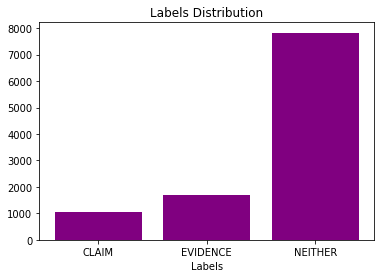

In [238]:
import pandas as pd
import matplotlib.pyplot as plt
labels_count=df.groupby('label').count()
plt.bar(labels_count.index.values, labels_count['sentence'], color='purple')
plt.title('Labels Distribution')
plt.xlabel('Labels')
plt.show()

### Lexicon - Words Distribution

#### Most common words in the whole dataset

In [239]:
#convert the sentences in one string in order to be able to tokenize words
text = ' '.join(df['sentence'].tolist())
text

'Concordance Between Different Amyloid Immunoassays and Visual Amyloid Positron Emission Tomographic Assessment Importance Visual assessment of amyloid positron emission tomographic (PET) images has been approved by regulatory authorities for clinical use. Several immunoassays have been developed to measure β-amyloid (Aβ) 42 in cerebrospinal fluid (CSF). The agreement between CSF Aβ42 measures from different immunoassays and visual PET readings may influence the use of CSF biomarkers and/or amyloid PET assessment in clinical practice and trials. Objective To determine the concordance between CSF Aβ42 levels measured using 5 different immunoassays and visual amyloid PET analysis. Design, Setting, and Participants The study included 262 patients with mild cognitive impairment or subjective cognitive decline from the Swedish BioFINDER (Biomarkers for Identifying Neurodegenerative Disorders Early and Reliably) cohort (recruited from September 1, 2010, through December 31, 2014) who had und

In [240]:
#tokenize words
!pip install nltk
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
tokenized_word=word_tokenize(text)
#print(tokenized_word)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [241]:
#find the most common words
from nltk.probability import FreqDist
fdist = FreqDist(tokenized_word)
#print(fdist)

In [242]:
#the 2 most common words
fdist.most_common(2)

[(',', 10672), ('the', 10100)]

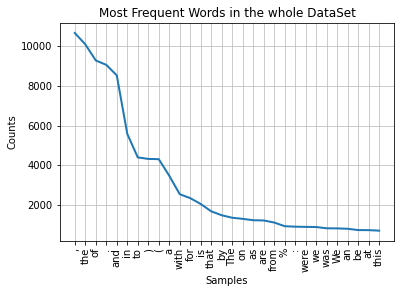

In [243]:
#Frequency Distribution Plot
import matplotlib.pyplot as plt
fdist.plot(30,cumulative=False, title= 'Most Frequent Words in the whole DataSet')
plt.show()

As we can see there are several problems at our most common words:

1.   We see the word "the" twice, with capital T and lower t.
2.   The most common words are not offering any information for the text since they are "stopwords".

1.   We have a lot of symbols "),(,%,..".






##### 1. Lower all letters

In [244]:
sent = df['sentence'].str.lower().tolist()
#sent

##### 2. Delete StopWords
Stopwords are considered as noise in the text.

In [245]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))
#print(stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [246]:
text2 = ' '.join(sent)
tokenized_word2 = word_tokenize(text2)
#tokenized_word2

In [247]:
filtered_sent=[]
for w in tokenized_word2:
    if w not in stop_words:
        filtered_sent.append(w)

##### 3. Delete Symbols

In [248]:
import string 
symbols = string.punctuation
symbols

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [249]:
filtered_sent2=[]
for w in filtered_sent:
  if w not in symbols:
        filtered_sent2.append(w)

##### 4. Word Lemmatization

In [250]:
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()
lem_words=[]
for w in filtered_sent2:
    lem_words.append(lem.lemmatize(w,pos="v"))
#lem_words

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


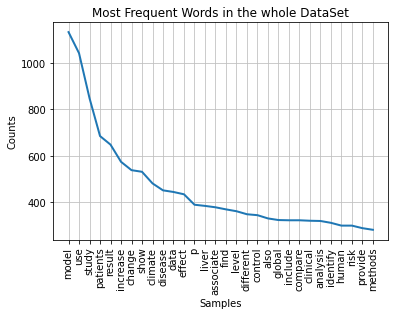

In [251]:
fdist2 = FreqDist(lem_words)
fdist2.plot(30,cumulative=False, title= 'Most Frequent Words in the whole DataSet')
plt.show()

In [252]:
# Custom Colormap
from matplotlib.colors import LinearSegmentedColormap
colors = ["#000000", "#111111", "#101010", "#121212", "#212121", "#222222"]
cmap = LinearSegmentedColormap.from_list("mycmap", colors)

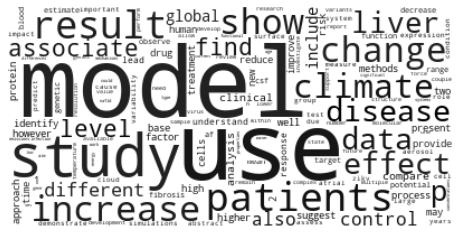

In [253]:
from collections import Counter
dictionary=Counter(lem_words)
import matplotlib.pyplot as plt
from wordcloud import WordCloud

cloud = WordCloud(background_color="white",colormap=cmap).generate_from_frequencies(dictionary)
plt.figure(figsize=(8,6))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Most common words for Claims
We will follow the same procedure as before but only for the Claims.

In [254]:
df_claim = df[df['label']=="CLAIM"]
df_claim

,doc_id,sentence,label
15,0,Conclusions and Relevance Concentrations of CS...,CLAIM
16,0,These findings suggest the benefit of implemen...,CLAIM
30,1,The increases in both neurofilament light and ...,CLAIM
31,1,Further investigations will be required to stu...,CLAIM
32,1,These preliminary findings demand that we ques...,CLAIM
...,...,...,...
10496,1008,Drought hazard probability maps can contribute...,CLAIM
10531,1011,The methodology proposed in this analysis prov...,CLAIM
10556,1014,Our preliminary results on coarse lattices sho...,CLAIM
10564,1015,"These findings have wide implications, ranging...",CLAIM


In [255]:
sent_cl = df_claim['sentence'].str.lower().tolist()
#sent

In [256]:
text2_cl = ' '.join(sent_cl)
tokenized_word2_cl = word_tokenize(text2_cl)
#tokenized_word2

In [257]:
filtered_sent_cl=[]
for w in tokenized_word2_cl:
    if w not in stop_words:
        filtered_sent_cl.append(w)

In [258]:
filtered_sent2_cl=[]
for w in filtered_sent_cl:
    if w not in symbols:
        filtered_sent2_cl.append(w)

In [259]:
lem_words_cl=[]
for w in filtered_sent2_cl:
    lem_words_cl.append(lem.lemmatize(w,pos="v"))
#lem_words

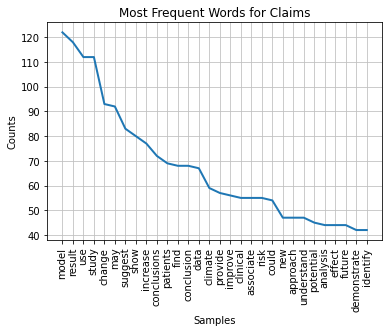

In [260]:
fdist2_cl = FreqDist(lem_words_cl)
fdist2_cl.plot(30,cumulative=False, title= 'Most Frequent Words for Claims')
plt.show()

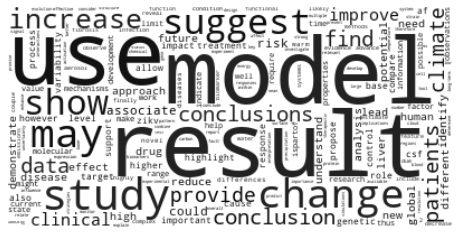

In [261]:
from collections import Counter
dictionary=Counter(lem_words_cl)
import matplotlib.pyplot as plt
from wordcloud import WordCloud

cloud = WordCloud(background_color="white",colormap=cmap).generate_from_frequencies(dictionary)
plt.figure(figsize=(8,6))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

(-0.5, 602.5, 687.5, -0.5)

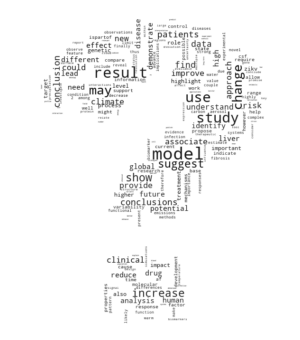

In [262]:
dictionary=Counter(lem_words_cl)
from PIL import Image
import numpy as np
med_mask = np.array(Image.open("claim.png"))
# Custom Colormap
from matplotlib.colors import LinearSegmentedColormap
colors = ["#000000", "#111111", "#101010", "#121212", "#212121", "#222222"]
cmap = LinearSegmentedColormap.from_list("mycmap", colors)

wc = WordCloud(background_color="white", mask=med_mask, colormap=cmap)
wc.generate_from_frequencies(dictionary)
plt.figure(figsize=(8,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

#### Most common words for Evidence
We will follow the same procedure now for Evidence.

In [263]:
df_evid = df[df['label']=="EVIDENCE"]
df_evid

,doc_id,sentence,label
8,0,Main Outcomes and Measures The concordance of ...,EVIDENCE
9,0,"Results Of 262 participants (mean [SD] age, 70...",EVIDENCE
10,0,The mass spectrometry–derived Aβ42 values show...,EVIDENCE
11,0,The signal in the classic Aβ42-INNOTEST assay ...,EVIDENCE
12,0,"However, the classic Aβ42-INNOTEST assay showe...",EVIDENCE
...,...,...,...
10492,1008,Our results demonstrate that the generalized P...,EVIDENCE
10494,1008,"Spatially, our estimations suggest a higher pr...",EVIDENCE
10530,1011,These show that higher values of P* generally ...,EVIDENCE
10554,1014,Our study generalizes a previous one by Fukush...,EVIDENCE


In [264]:
sent_ev = df_evid['sentence'].str.lower().tolist()
#sent

In [265]:
text2_ev = ' '.join(sent_ev)
tokenized_word2_ev = word_tokenize(text2_ev)
#tokenized_word2

In [266]:
filtered_sent_ev=[]
for w in tokenized_word2_ev:
    if w not in stop_words:
        filtered_sent_ev.append(w)

In [267]:
filtered_sent2_ev=[]
for w in filtered_sent_ev:
    if w not in symbols:
        filtered_sent2_ev.append(w)

In [268]:
lem_words_ev=[]
for w in filtered_sent2_ev:
    lem_words_ev.append(lem.lemmatize(w,pos="v"))
#lem_words

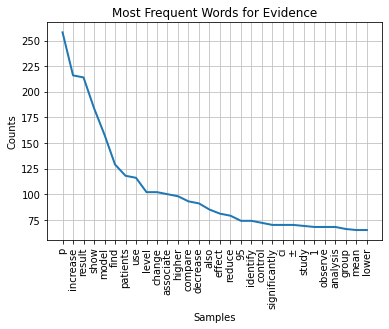

In [269]:
fdist2_ev = FreqDist(lem_words_ev)
fdist2_ev.plot(30,cumulative=False, title= 'Most Frequent Words for Evidence')
plt.show()

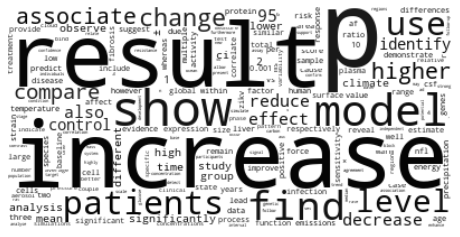

In [270]:
from collections import Counter
dictionary=Counter(lem_words_ev)
import matplotlib.pyplot as plt
from wordcloud import WordCloud

cloud = WordCloud(background_color="white",colormap=cmap).generate_from_frequencies(dictionary)
plt.figure(figsize=(8,6))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

(-0.5, 611.5, 458.5, -0.5)

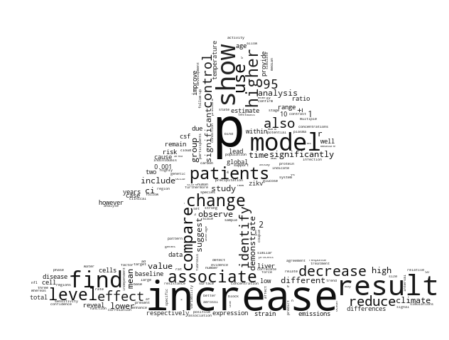

In [271]:
dictionary=Counter(lem_words_ev)
from PIL import Image
import numpy as np
med_mask = np.array(Image.open("6770093_preview.png"))


wc = WordCloud(background_color="white", mask=med_mask, colormap=cmap)
wc.generate_from_frequencies(dictionary)
plt.figure(figsize=(8,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

#### Words in Claim and not in Evidence

In [272]:
x = Counter(lem_words_cl)
cl_sort = sorted(x, key=x.get, reverse=True)

In [273]:
x = Counter(lem_words_ev)
ev_sort = sorted(x, key=x.get, reverse=True)

In [274]:
#top 50 words
claim_words_freq = np.setdiff1d(cl_sort[:50],ev_sort[:50])
#claim_words_freq

In [275]:
#all words
claim_words = np.setdiff1d(lem_words_cl,lem_words_ev)
#claim_words

#### Words in Evidence and not in **Claim**

In [276]:
#top 50 words
ev_words_freq = np.setdiff1d(ev_sort[:50],cl_sort[:50])
#ev_words_freq

In [277]:
#all words
ev_words = np.setdiff1d(lem_words_ev,lem_words_cl)
#ev_words

### Labels Classifier

In [278]:
def labels_classifier(sentences, words_for_claims, words_for_evidence):
  labels = []
  #sentence processing
  sentences = sentences.str.lower().tolist()
  for i in range(0,len(sentences)):
    #go to each sentence
    sent = sentences[i]
    words_sent = word_tokenize(sent)
    lem_sent_words=[]
    for w in words_sent:
      lem_sent_words.append(lem.lemmatize(w,pos="v")) 
    #assing label
    cl = 0
    ev = 0
    for j in range(0,len(lem_sent_words)):
      if lem_sent_words[j] in words_for_claims:
        cl = cl + 1
      elif lem_sent_words[j] in words_for_evidence:
        ev = ev + 1
    if ev > cl:
      labels.append("EVIDENCE")
    elif cl > ev:
      labels.append("CLAIM")
    else:
      labels.append("NEITHER")
  return(labels)

##### Classifier Evaluation

###### Using top 30 words

In [279]:
labels1 = labels_classifier(df['sentence'],cl_sort[:30],ev_sort[:30])

In [280]:
print(labels1)

['NEITHER', 'CLAIM', 'NEITHER', 'CLAIM', 'CLAIM', 'CLAIM', 'NEITHER', 'CLAIM', 'EVIDENCE', 'NEITHER', 'EVIDENCE', 'NEITHER', 'EVIDENCE', 'EVIDENCE', 'EVIDENCE', 'CLAIM', 'CLAIM', 'NEITHER', 'NEITHER', 'CLAIM', 'NEITHER', 'CLAIM', 'NEITHER', 'NEITHER', 'CLAIM', 'NEITHER', 'CLAIM', 'EVIDENCE', 'EVIDENCE', 'CLAIM', 'CLAIM', 'CLAIM', 'CLAIM', 'NEITHER', 'NEITHER', 'NEITHER', 'CLAIM', 'NEITHER', 'CLAIM', 'NEITHER', 'NEITHER', 'NEITHER', 'EVIDENCE', 'CLAIM', 'CLAIM', 'CLAIM', 'CLAIM', 'CLAIM', 'CLAIM', 'NEITHER', 'CLAIM', 'CLAIM', 'CLAIM', 'CLAIM', 'CLAIM', 'CLAIM', 'CLAIM', 'NEITHER', 'NEITHER', 'NEITHER', 'NEITHER', 'CLAIM', 'NEITHER', 'CLAIM', 'NEITHER', 'CLAIM', 'CLAIM', 'CLAIM', 'CLAIM', 'CLAIM', 'CLAIM', 'NEITHER', 'NEITHER', 'NEITHER', 'CLAIM', 'CLAIM', 'NEITHER', 'CLAIM', 'CLAIM', 'CLAIM', 'CLAIM', 'NEITHER', 'CLAIM', 'NEITHER', 'NEITHER', 'CLAIM', 'CLAIM', 'NEITHER', 'CLAIM', 'CLAIM', 'NEITHER', 'EVIDENCE', 'NEITHER', 'CLAIM', 'CLAIM', 'NEITHER', 'NEITHER', 'NEITHER', 'NEITHER', 'EV

In [281]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true=df['label'], y_pred=labels1)
#conf_matrix
df_cm = pd.DataFrame(conf_matrix, index=["CLAIM","EVIDENCE","NEITHER"], columns=["CLAIM","EVIDENCE","NEITHER"])
fig = plt.figure(figsize=(10,7))
df_cm

,CLAIM,EVIDENCE,NEITHER
CLAIM,777,56,215
EVIDENCE,816,385,499
NEITHER,3797,669,3361


<Figure size 720x504 with 0 Axes>

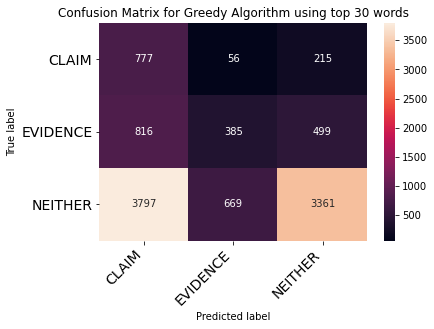

In [282]:
import seaborn as sns
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),
                                 rotation=0,
                                 ha='right',
                                 fontsize=14)

heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),
                                 rotation=45,
                                 ha='right',
                                 fontsize=14)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix for Greedy Algorithm using top 30 words')
plt.show()

###### Using distinct words
i.e., words that are only in Claim or Evidence

In [283]:
labels2 = labels_classifier(df['sentence'],claim_words,ev_words)

In [284]:
conf_matrix = confusion_matrix(y_true=df['label'], y_pred=labels2)
#conf_matrix
df_cm = pd.DataFrame(conf_matrix, index=["CLAIM","EVIDENCE","NEITHER"], columns=["CLAIM","EVIDENCE","NEITHER"])
fig = plt.figure(figsize=(10,7))
df_cm

,CLAIM,EVIDENCE,NEITHER
CLAIM,865,1,182
EVIDENCE,11,1554,135
NEITHER,1992,3253,2582


<Figure size 720x504 with 0 Axes>

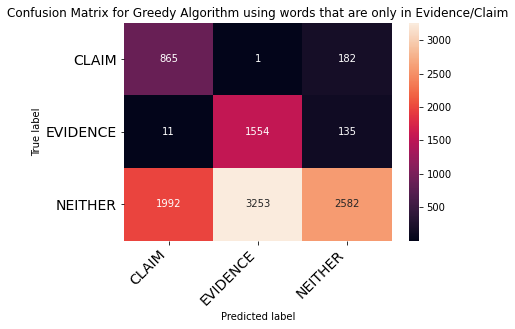

In [285]:
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),
                                 rotation=0,
                                 ha='right',
                                 fontsize=14)

heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),
                                 rotation=45,
                                 ha='right',
                                 fontsize=14)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix for Greedy Algorithm using words that are only in Evidence/Claim')
plt.show()

###### Using distinct top 50 words
i.e., words that are only in Claim or Evidence from the top 50

In [286]:
labels3 = labels_classifier(df['sentence'],claim_words_freq,ev_words_freq)

In [287]:
conf_matrix = confusion_matrix(y_true=df['label'], y_pred=labels3)
#conf_matrix
df_cm = pd.DataFrame(conf_matrix, index=["CLAIM","EVIDENCE","NEITHER"], columns=["CLAIM","EVIDENCE","NEITHER"])
fig = plt.figure(figsize=(10,7))
df_cm

,CLAIM,EVIDENCE,NEITHER
CLAIM,560,111,377
EVIDENCE,314,677,709
NEITHER,2225,1402,4200


<Figure size 720x504 with 0 Axes>

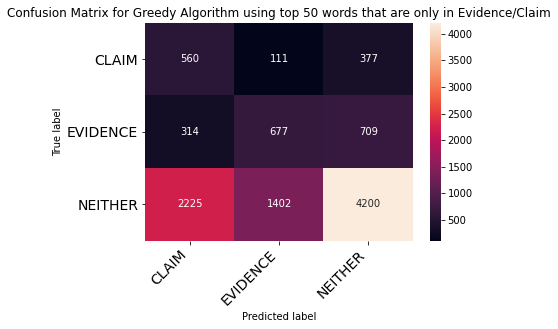

In [288]:
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),
                                 rotation=0,
                                 ha='right',
                                 fontsize=14)

heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),
                                 rotation=45,
                                 ha='right',
                                 fontsize=14)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix for Greedy Algorithm using top 50 words that are only in Evidence/Claim')
plt.show()

###### Check Agreement

In [289]:
def agreement(list1,list2):
  sum = 0
  if len(list1) == len(list2):
    for i in range(0,len(list1)):
      if list1[i] == list2[i]:
        sum = sum + 1
  return(sum)

In [290]:
agreement(labels1,df['label'])/len(df['label'])

0.42770685579196216

In [291]:
agreement(labels2,df['label'])/len(df['label'])

0.47290780141843974

In [292]:
agreement(labels3,df['label'])/len(df['label'])

0.5141371158392435

## FastText Approach

### Installing FastText

In [293]:
!pip install fasttext

In [294]:
import fasttext
#help(fasttext.FastText)

### Argument Labels


#### Preparing the data

In [295]:
#split to train and validation
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df[["sentence"]], df['label'], test_size=0.3, random_state=1)

In [296]:
dataset = pd.concat([X_train, y_train], axis=1)
ds = pd.concat([X_test, y_test], axis=1)

In [297]:
# NLP Preprocessing
from gensim.utils import simple_preprocess

# NLP Preprocess
dataset.iloc[:, 0] = dataset.iloc[:, 0].apply(lambda x: ' '.join(simple_preprocess(x)))
ds.iloc[:, 0] = ds.iloc[:, 0].apply(lambda x: ' '.join(simple_preprocess(x)))

# Prefixing each row of the category column with '__label__'
dataset.iloc[:, 1] = dataset.iloc[:, 1].apply(lambda x: '__label__' + x)
ds.iloc[:, 1] = ds.iloc[:, 1].apply(lambda x: '__label__' + x)

In [298]:
dataset

,sentence,label
4053,this perspective discusses new evaluation appr...,__label__CLAIM
1637,the building sector is thus key area to consid...,__label__CLAIM
7786,understanding the relationship between egg and...,__label__NEITHER
9912,this indicates that those sensors that,__label__NEITHER
5334,innovation our work evidenced the unique role ...,__label__NEITHER
...,...,...
2895,ensemble based replica exchange alchemical fre...,__label__NEITHER
7813,the methylation variability signature was then...,__label__EVIDENCE
905,background recently the anti sense oligonucleo...,__label__NEITHER
5192,we observe noise induced transitions between t...,__label__NEITHER


In [299]:
import csv
dataset[['sentence', 'label']].to_csv('train.txt', 
                                          index = False, 
                                          sep = ' ',
                                          header = None, 
                                          quoting = csv.QUOTE_NONE, 
                                          quotechar = "", 
                                          escapechar = " ")
ds[['sentence', 'label']].to_csv('test.txt', 
                                     index = False, 
                                     sep = ' ',
                                     header = None, 
                                     quoting = csv.QUOTE_NONE, 
                                     quotechar = "", 
                                     escapechar = " ")

#### First Classifier

In [300]:
# Training the fastText classifier
model = fasttext.train_supervised('train.txt')
# Evaluating performance on the entire test file
model.test('test.txt')  

(3173, 0.7560668137409392, 0.7560668137409392)

We used the test method to evaluate my classifier on the entire test dataset (3173 samples), which yielded values for precision at one as 0.75 and recall of one as 0.75 as well.

The precision is the number of the correct labels predicted by the classifier among all the labels and the recall the number of labels successfully predicted among the real labels.

In [301]:
ds.iloc[2, 1]

'__label__NEITHER'

In [302]:
# Predicting on a single input
model.predict(ds.iloc[2, 0])

(('__label__NEITHER',), array([0.92070341]))

The predict method is used to predict the most likely label for a given input. We chose an observation which had label "Neither" and tested the model against it. As you can see above, it correctly predicted the label and did so with a probability of 92,07%.

#### Making the model better

With a few steps, we were able to improve precision:

* preprocessing the data
* changing the number of epochs (using the option -epoch, standard range [5 - 50])
* changing the learning rate (using the option -lr, standard range [0.1 - 1.0])
* using word n-grams (using the option -wordNgrams, standard range [1 - 5]).

train_supervised parameters
*    **input**             --> training file path (required)
*    **lr**                --> learning rate [0.1]
*    **dim**               --> size of word vectors [100]
*    **ws**                --> size of the context window [5]
*    **epoch**             --> number of epochs [5]
*    **minCount**          --> minimal number of word occurences [1]
*    **minCountLabel**     --> minimal number of label occurences [1]
*    **minn**              --> min length of char ngram [0]
*    **maxn**              --> max length of char ngram [0]
*    **neg**               --> number of negatives sampled [5]
*    **wordNgrams**        --> max length of word ngram [1]
*    **loss**              --> loss function {ns, hs, softmax, ova} [softmax]
*    **bucket**            --> number of buckets [2000000]
*    **thread**            --> number of threads [number of cpus]
*   **lrUpdateRate**       --> change the rate of updates for the learning rate [100]
*    **t**                 --> sampling threshold [0.0001]
*    **label**             --> label prefix ['__ label __']
*    **verbose**           --> verbose [2]
*    **pretrainedVectors** --> pretrained word vectors (.vec file) for supervised learning []

##### Best Value for learning rate

A way to change the learning speed of our model is to increase (or decrease) the learning rate of the algorithm. This corresponds to how much the model changes after processing each example. A learning rate of 0 would mean that the model does not change at all, and thus, does not learn anything. Good values of the learning rate are in the range 0.1 - 1.0.

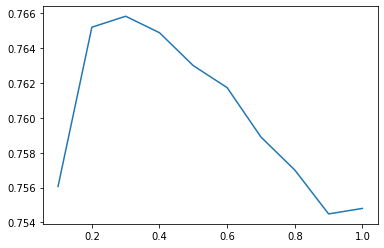

In [303]:
lr = []
for i in np.arange(0.1,1.1,0.1):
  model2 = fasttext.train_supervised('train.txt',lr = i)
  lr.append(model2.test('test.txt')[1]) 
plt.plot(np.arange(0.1,1.1,0.1),lr)

In [304]:
print(f"Best learning rate value is: {np.arange(0.1,1.1,0.1)[lr.index(max(lr))]}")

Best learning rate value is: 0.30000000000000004


##### Best size for words vector

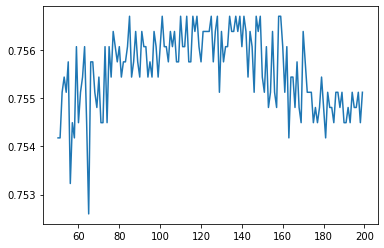

In [305]:
dim = []
for i in range(50,200):
  model4 = fasttext.train_supervised('train.txt', dim = i)
  dim.append(model4.test('test.txt')[1])  
plt.plot(range(50,200),dim)

In [306]:
print(f"Best size of word vector is: {range(50,200)[dim.index(max(dim))]}")

Best size of word vector is: 85


##### Best size for the context window

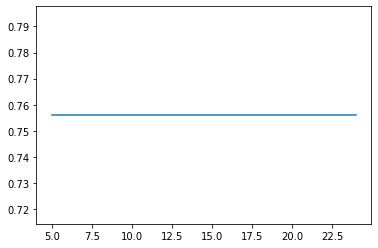

In [307]:
cw = []
for i in range(5,25):
  model1 = fasttext.train_supervised('train.txt', ws = i)
  cw.append(model1.test('test.txt')[1])  
plt.plot(range(5,25),cw)

##### Best epoch value
The times that fasttext sees each training example 

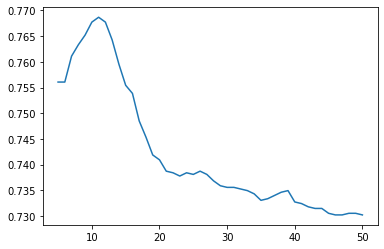

In [308]:
ep = []
for i in range(5,51):
  model3 = fasttext.train_supervised('train.txt',epoch = i)
  ep.append(model3.test('test.txt')[1]) 
plt.plot(range(5,51),ep)

In [309]:
print(f"Best epoch value is: {range(5,51)[ep.index(max(ep))]}")

Best epoch value is: 11


##### Best WordNgrams value

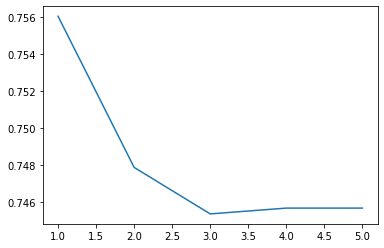

In [310]:
wng = []
for i in range(1,6):
  model5 = fasttext.train_supervised('train.txt', wordNgrams = i)
  wng.append(model5.test('test.txt')[1]) 
plt.plot(range(1,6),wng)

In [311]:
print(f"Best wordNgrams value is: {range(1,6)[wng.index(max(wng))]}")

Best wordNgrams value is: 1


##### Best bucket number

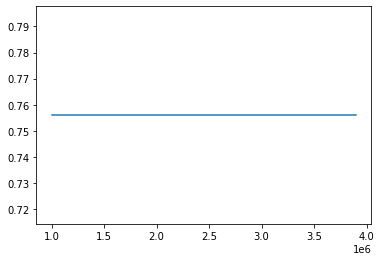

In [312]:
bckt = []
for i in range(1000000,4000000,100000):
  model6 = fasttext.train_supervised('train.txt', bucket = i)
  bckt.append(model6.test('test.txt')[1]) 
plt.plot(range(1000000,4000000,100000),bckt) 

##### The final model

In [313]:
model_comb = fasttext.train_supervised('train.txt', lr=0.3, epoch = 11, wordNgrams = 1, dim = 85)
model_comb.test('test.txt') 

(3173, 0.7437756066813741, 0.7437756066813741)

In [314]:
model_final = fasttext.train_supervised('train.txt', lr=0.3, epoch = 11, wordNgrams = 2, dim = 85)
model_final.test('test.txt') 

(3173, 0.7711944531988655, 0.7711944531988655)

In [315]:
model_final2 = fasttext.train_supervised('train.txt', lr=0.3, epoch = 11, wordNgrams = 2, dim = 100)
model_final2.test('test.txt') 

(3173, 0.7718247715096124, 0.7718247715096124)

In [316]:
model.test_label('test.txt')

{'__label__CLAIM': {'f1score': 1.0, 'precision': 0.5, 'recall': nan},
 '__label__EVIDENCE': {'f1score': 0.9387755102040817,
  'precision': 0.46938775510204084,
  'recall': nan},
 '__label__NEITHER': {'f1score': 1.543941411451398,
  'precision': 0.771970705725699,
  'recall': nan}}

In [317]:
model_final2.test_label('test.txt')

{'__label__CLAIM': {'f1score': 0.9932885906040269,
  'precision': 0.4966442953020134,
  'recall': nan},
 '__label__EVIDENCE': {'f1score': 1.0632183908045978,
  'precision': 0.5316091954022989,
  'recall': nan},
 '__label__NEITHER': {'f1score': 1.6367713004484306,
  'precision': 0.8183856502242153,
  'recall': nan}}

In [318]:
ds['pred_label'] = " "
for i in range(0,len(ds['sentence'])):
  ds['pred_label'].iloc[i] = model_final2.predict(ds['sentence'].iloc[i])
  ds['pred_label'].iloc[i] = str(ds['pred_label'].iloc[i]).split("'")[1] #keep only labels

In [319]:
conf_matrix = confusion_matrix(y_true=ds['label'], y_pred=ds['pred_label'])
#conf_matrix

In [320]:
df_cm = pd.DataFrame(conf_matrix, index=["CLAIM","EVIDENCE","NEITHER"], columns=["CLAIM","EVIDENCE","NEITHER"])
fig = plt.figure(figsize=(10,7))
df_cm

,CLAIM,EVIDENCE,NEITHER
CLAIM,74,36,200
EVIDENCE,26,185,286
NEITHER,49,127,2190


<Figure size 720x504 with 0 Axes>

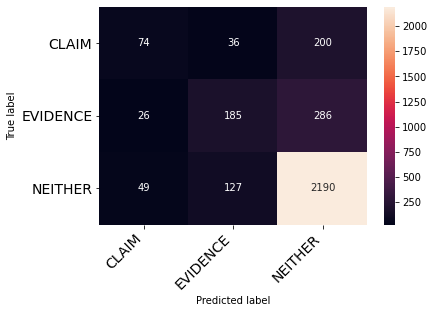

In [321]:
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),
                                 rotation=0,
                                 ha='right',
                                 fontsize=14)

heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),
                                 rotation=45,
                                 ha='right',
                                 fontsize=14)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [322]:
###Classification report

from sklearn import metrics
report = metrics.classification_report(ds['label'], ds['pred_label'], output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
__label__CLAIM,0.496644,0.238710,0.322440,310.000000
__label__EVIDENCE,0.531609,0.372233,0.437870,497.000000
__label__NEITHER,0.818386,0.925613,0.868703,2366.000000
accuracy,0.771825,0.771825,0.771825,0.771825
macro avg,0.615546,0.512185,0.543004,3173.000000
weighted avg,0.742033,0.771825,0.747850,3173.000000


### Structure Labels

In [323]:
data_str = load_corpus('dataset_aueb_structure_v2.json') #, label_mapping=label2id)
print(f'Dataset length: {len(data_str)} abstracts')
data_str.sample(5)

Dataset length: 1017 abstracts


,document,sentences,labels
708,doi: 10.1126/science.aav2211,[Organic synthesis in a modular robotic system...,"[NEITHER, BACKGROUND, OBJECTIVE, METHOD, METHO..."
807,doi: 10.1186/s13075-019-1824-z,[Do musculoskeletal ultrasound and magnetic re...,"[NEITHER, BACKGROUND, BACKGROUND, OBJECTIVE, M..."
479,doi: 10.1038/s41598-018-25562-x,[Novel bifunctional cap for simultaneous elect...,"[NEITHER, BACKGROUND, BACKGROUND, BACKGROUND, ..."
414,doi: 10.1038/s41421-019-0140-8,[A new class of broadly neutralizing antibodie...,"[NEITHER, BACKGROUND, BACKGROUND, BACKGROUND, ..."
652,doi: 10.1098/rstb.2019.0512,[Changes in net ecosystem exchange over Europe...,"[NEITHER, BACKGROUND, BACKGROUND, OBJECTIVE, M..."


In [324]:
sentences2 = data_str['sentences'].explode().reset_index().rename(
    columns={'index': 'doc_id', 'sentences': 'sentence'})
sentences2

,doc_id,sentence
0,0,Concordance Between Different Amyloid Immunoas...
1,0,Importance Visual assessment of amyloid positr...
2,0,Several immunoassays have been developed to me...
3,0,The agreement between CSF Aβ42 measures from d...
4,0,Objective To determine the concordance between...
...,...,...
10570,1016,"Instead, SBPs sample a range of conformations ..."
10571,1016,Certain non-transported ligands leave the stru...
10572,1016,"Intriguingly, in some cases, similar SBP confo..."
10573,1016,"In this case, the inability for transport aris..."


In [325]:
labels2 = data_str['labels'].explode().reset_index().rename(
    columns={'index': 'doc_id', 'labels': 'label'})
labels2

,doc_id,label
0,0,NEITHER
1,0,BACKGROUND
2,0,BACKGROUND
3,0,BACKGROUND
4,0,OBJECTIVE
...,...,...
10570,1016,METHOD
10571,1016,RESULT
10572,1016,RESULT
10573,1016,RESULT


In [326]:
df_str = pd.concat([sentences2,labels2['label']],axis=1)
df_str

,doc_id,sentence,label
0,0,Concordance Between Different Amyloid Immunoas...,NEITHER
1,0,Importance Visual assessment of amyloid positr...,BACKGROUND
2,0,Several immunoassays have been developed to me...,BACKGROUND
3,0,The agreement between CSF Aβ42 measures from d...,BACKGROUND
4,0,Objective To determine the concordance between...,OBJECTIVE
...,...,...,...
10570,1016,"Instead, SBPs sample a range of conformations ...",METHOD
10571,1016,Certain non-transported ligands leave the stru...,RESULT
10572,1016,"Intriguingly, in some cases, similar SBP confo...",RESULT
10573,1016,"In this case, the inability for transport aris...",RESULT


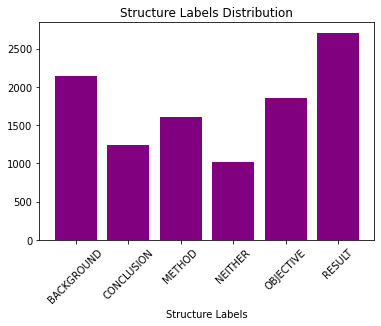

In [327]:
labels_count2=df_str.groupby('label').count()
plt.bar(labels_count2.index.values, labels_count2['sentence'], color='purple')
plt.title('Structure Labels Distribution')
plt.xlabel('Structure Labels')
plt.xticks(rotation=45)
plt.show()

#### Preparing the data

In [328]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    df_str[["sentence"]], df_str['label'], test_size=0.3, random_state=1)

In [329]:
ds_train = pd.concat([X_train2, y_train2], axis=1)
ds_test = pd.concat([X_test2, y_test2], axis=1)

In [330]:
# NLP Preprocess
ds_train.iloc[:, 0] = ds_train.iloc[:, 0].apply(lambda x: ' '.join(simple_preprocess(x)))
ds_test.iloc[:, 0] = ds_test.iloc[:, 0].apply(lambda x: ' '.join(simple_preprocess(x)))

# Prefixing each row of the category column with '__label__'
ds_train.iloc[:, 1] = ds_train.iloc[:, 1].apply(lambda x: '__label__' + x)
ds_test.iloc[:, 1] = ds_test.iloc[:, 1].apply(lambda x: '__label__' + x)

In [331]:
ds_train

,sentence,label
4053,this perspective discusses new evaluation appr...,__label__CONCLUSION
1637,the building sector is thus key area to consid...,__label__BACKGROUND
7786,understanding the relationship between egg and...,__label__NEITHER
9912,this indicates that those sensors that,__label__OBJECTIVE
5334,innovation our work evidenced the unique role ...,__label__CONCLUSION
...,...,...
2895,ensemble based replica exchange alchemical fre...,__label__NEITHER
7813,the methylation variability signature was then...,__label__RESULT
905,background recently the anti sense oligonucleo...,__label__BACKGROUND
5192,we observe noise induced transitions between t...,__label__RESULT


In [332]:
ds_train[['sentence', 'label']].to_csv('str_train.txt', 
                                          index = False, 
                                          sep = ' ',
                                          header = None, 
                                          quoting = csv.QUOTE_NONE, 
                                          quotechar = "", 
                                          escapechar = " ")
ds_test[['sentence', 'label']].to_csv('str_test.txt', 
                                     index = False, 
                                     sep = ' ',
                                     header = None, 
                                     quoting = csv.QUOTE_NONE, 
                                     quotechar = "", 
                                     escapechar = " ")

#### First Classifier

In [333]:
# Training the fastText classifier
model_str = fasttext.train_supervised('str_train.txt')
# Evaluating performance on the entire test file
model_str.test('str_test.txt')  

(3173, 0.5524739993696817, 0.5524739993696817)

In [334]:
ds_test.iloc[2, 1]

'__label__NEITHER'

In [335]:
# Predicting on a single input
model_str.predict(ds_test.iloc[2, 0])

(('__label__NEITHER',), array([0.34293234]))

#### Best Value for learning rate

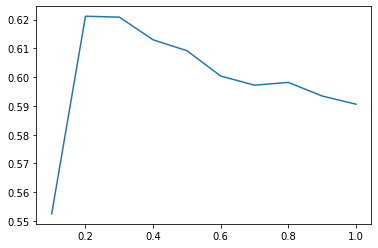

In [336]:
lr = []
for i in np.arange(0.1,1.1,0.1):
  model_str2 = fasttext.train_supervised('str_train.txt',lr = i)
  lr.append(model_str2.test('str_test.txt')[1]) 
plt.plot(np.arange(0.1,1.1,0.1),lr)

In [337]:
print(f"Best learning rate value is: {np.arange(0.1,1.1,0.1)[lr.index(max(lr))]}")

Best learning rate value is: 0.2


#### Best size for words vector

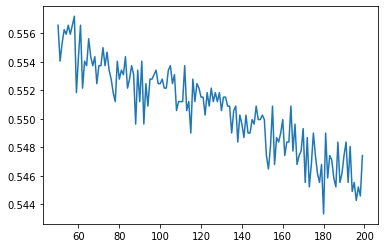

In [338]:
dim = []
for i in range(50,200):
  model_str4 = fasttext.train_supervised('str_train.txt', dim = i)
  dim.append(model_str4.test('str_test.txt')[1])  
plt.plot(range(50,200),dim)

In [339]:
print(f"Best size of word vector is: {range(50,200)[dim.index(max(dim))]}")

Best size of word vector is: 58


#### Best size for the context window

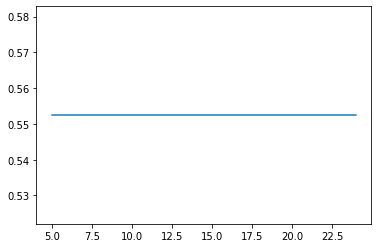

In [340]:
cw = []
for i in range(5,25):
  model_str1 = fasttext.train_supervised('str_train.txt', ws = i)
  cw.append(model_str1.test('str_test.txt')[1])  
plt.plot(range(5,25),cw)

#### Best epoch value

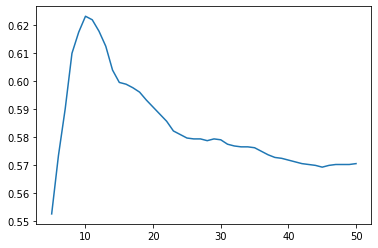

In [341]:
ep = []
for i in range(5,51):
  model_str3 = fasttext.train_supervised('str_train.txt',epoch = i)
  ep.append(model_str3.test('str_test.txt')[1]) 
plt.plot(range(5,51),ep)

In [342]:
print(f"Best epoch value is: {range(5,51)[ep.index(max(ep))]}")

Best epoch value is: 10


#### Best WordNgrams value

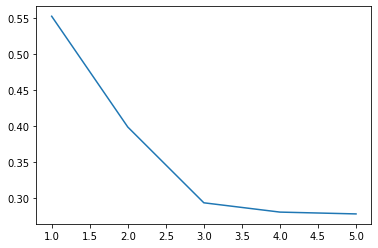

In [343]:
wng = []
for i in range(1,6):
  model_str5 = fasttext.train_supervised('str_train.txt', wordNgrams = i)
  wng.append(model_str5.test('str_test.txt')[1]) 
plt.plot(range(1,6),wng)

In [344]:
print(f"Best wordNgrams value is: {range(1,6)[wng.index(max(wng))]}")

Best wordNgrams value is: 1


#### Best bucket number

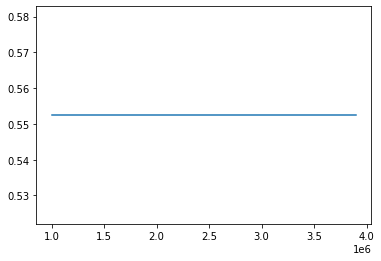

In [345]:
bckt = []
for i in range(1000000,4000000,100000):
  model_str6 = fasttext.train_supervised('str_train.txt', bucket = i)
  bckt.append(model_str6.test('str_test.txt')[1]) 
plt.plot(range(1000000,4000000,100000),bckt) 

#### The final model

In [346]:
modelstr_comb = fasttext.train_supervised('str_train.txt', lr=0.2, epoch = 10, wordNgrams = 1, dim = 58)
modelstr_comb.test('str_test.txt') 

(3173, 0.5956508036558462, 0.5956508036558462)

In [347]:
modelstr_comb2 = fasttext.train_supervised('str_train.txt', lr=0.1, epoch = 10, wordNgrams = 1, dim = 58)
modelstr_comb2.test('str_test.txt') 

(3173, 0.6255909234163253, 0.6255909234163253)

In [348]:
modelstr_comb2.test_label('str_test.txt')

{'__label__BACKGROUND': {'f1score': 1.2432432432432432,
  'precision': 0.6216216216216216,
  'recall': nan},
 '__label__CONCLUSION': {'f1score': 1.1307420494699647,
  'precision': 0.5653710247349824,
  'recall': nan},
 '__label__METHOD': {'f1score': 1.1594202898550725,
  'precision': 0.5797101449275363,
  'recall': nan},
 '__label__NEITHER': {'f1score': 1.5309446254071661,
  'precision': 0.7654723127035831,
  'recall': nan},
 '__label__OBJECTIVE': {'f1score': 1.302325581395349,
  'precision': 0.6511627906976745,
  'recall': nan},
 '__label__RESULT': {'f1score': 1.2135815991237677,
  'precision': 0.6067907995618839,
  'recall': nan}}

In [349]:
ds_test['pred_label'] = " "
for i in range(0,len(ds_test['sentence'])):
  ds_test['pred_label'].iloc[i] = modelstr_comb2.predict(ds_test['sentence'].iloc[i])
  ds_test['pred_label'].iloc[i] = str(ds_test['pred_label'].iloc[i]).split("'")[1] #keep only labels

In [350]:
conf_matrix2 = confusion_matrix(y_true=ds_test['label'], y_pred=ds_test['pred_label'])
#conf_matrix2

In [351]:
df_cm = pd.DataFrame(conf_matrix2, index=["BACKGROUN","CONCLUSION","METHOD","NEITHER","OBJECTIVE","RESULT"], columns=["BACKGROUN","CONCLUSION","METHOD","NEITHER","OBJECTIVE","RESULT"])
fig = plt.figure(figsize=(10,7))
df_cm

,BACKGROUN,CONCLUSION,METHOD,NEITHER,OBJECTIVE,RESULT
BACKGROUN,460,36,24,23,36,78
CONCLUSION,62,160,20,9,37,77
METHOD,49,13,240,8,51,108
NEITHER,35,7,6,235,24,34
OBJECTIVE,63,30,59,16,336,62
RESULT,71,37,65,16,32,554


<Figure size 720x504 with 0 Axes>

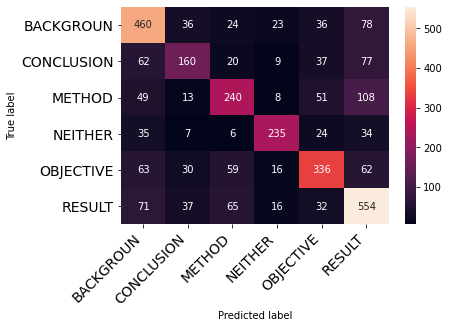

In [352]:
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),
                                 rotation=0,
                                 ha='right',
                                 fontsize=14)

heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),
                                 rotation=45,
                                 ha='right',
                                 fontsize=14)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [353]:
###Classification report
report = metrics.classification_report(ds_test['label'], ds_test['pred_label'], output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
__label__BACKGROUND,0.621622,0.700152,0.658554,657.000000
__label__CONCLUSION,0.565371,0.438356,0.493827,365.000000
__label__METHOD,0.579710,0.511727,0.543601,469.000000
__label__NEITHER,0.765472,0.689150,0.725309,341.000000
__label__OBJECTIVE,0.651163,0.593640,0.621072,566.000000
__label__RESULT,0.606791,0.714839,0.656398,775.000000
accuracy,0.625591,0.625591,0.625591,0.625591
macro avg,0.631688,0.607977,0.616460,3173.000000
weighted avg,0.626063,0.625591,0.622575,3173.000000


# **Abstract Clustering**

In [354]:
data_cit = load_corpus('dataset_aueb_citations_v2.json') #, label_mapping=label2id)
print(f'Dataset length: {len(data_cit)} abstracts')
data_cit.sample(5)

Dataset length: 1017 abstracts


,document,sentences,labels
704,doi: 10.1126/sciadv.aba2724,[Direct and seasonal legacy effects of the 201...,"[NEITHER, NEGATIVE, NEUTRAL, POSITIVE, NEGATIV..."
867,doi: 10.15252/embr.201642030,[High density of\n REC\n ...,"[NEITHER, POSITIVE, IRRELEVANT, POSITIVE, IRRE..."
552,doi: 10.1080/14760584.2018.1546582,[Durability of single-dose rVSV-ZEBOV vaccine ...,"[NEITHER, IRRELEVANT]"
797,doi: 10.1186/s13063-018-2523-9,[Antifibrotic and molecular aspects of rifaxim...,"[NEITHER, IRRELEVANT, NEUTRAL]"
142,doi: 10.1016/j.celrep.2018.09.048,[Genetic Architecture of Adaptive Immune Syste...,"[NEITHER, NEUTRAL, POSITIVE, POSITIVE, NEUTRAL..."


In [355]:
data_eu = pd.read_json (r'eu_calls.json', typ = 'series')
data_eu = pd.DataFrame(data_eu)
data_eu.reset_index(level=0, inplace=True)
data_eu.columns = ['eu_call','text']
#print(f'Dataset length: {len(data_eu)} abstracts')
data_eu.head()

,eu_call,text
0,H2020-EU.3.1.1.,"SOCIETAL CHALLENGES - Health, demographic chan..."
1,H2020-EU.1.1.,EXCELLENT SCIENCE - European Research Council ...
2,H2020-EU.3.1.6.,"SOCIETAL CHALLENGES - Health, demographic chan..."
3,H2020-EU.3.1.3.,"SOCIETAL CHALLENGES - Health, demographic chan..."
4,H2020-EU.1.3.1.,Fostering new skills by means of excellent ini...


In [356]:
for i in range(0,len(data_eu)):
  data_eu['text'][i] = data_eu['text'][i].split("\n")
  
print(f'Dataset length: {len(data_eu)} eu_calls')
data_eu.head()

Dataset length: 13 eu_calls


,eu_call,text
0,H2020-EU.3.1.1.,"[SOCIETAL CHALLENGES - Health, demographic cha..."
1,H2020-EU.1.1.,[EXCELLENT SCIENCE - European Research Council...
2,H2020-EU.3.1.6.,"[SOCIETAL CHALLENGES - Health, demographic cha..."
3,H2020-EU.3.1.3.,"[SOCIETAL CHALLENGES - Health, demographic cha..."
4,H2020-EU.1.3.1.,[Fostering new skills by means of excellent in...


### Document Embeddings

In [357]:
def load_data(path, label_mapping=None):
    with open(path) as fp:
        corpus = json.load(fp)

    documents, texts, labels, eu_call, project = [], [], [], [], []
    for abstract in corpus:
        documents.append(abstract)
        texts.append(corpus[abstract]['sentences'])
        eu_call.append(corpus[abstract]['eu_call'])
        project.append(corpus[abstract]['project_objective'])
        if isinstance(label_mapping, dict):
            labels.append(
                [label_mapping[str(l).upper()]
                    for l in corpus[abstract]['labels']])
        else:
            labels.append([str(l).upper() for l in corpus[abstract]['labels']])

    assert len(texts) == len(labels)
    data = pd.DataFrame(
        zip(documents, project, eu_call, texts, labels),
        columns=['document', 'project', 'eu_call', 'sentences', 'labels'])

    return data

data = load_data('dataset_aueb_argument_v3.json') #, label_mapping=label2id)
print(f'Dataset length: {len(data)} abstracts')
data.sample(5)

Dataset length: 1017 abstracts


,document,project,eu_call,sentences,labels
576,doi: 10.1088/1748-9326/ab4867,"Within the European Research Area (ERA), the E...",H2020-EU.3.5.1.,[Cold waves are getting milder in the northern...,"[NEITHER, NEITHER, NEITHER, NEITHER, EVIDENCE,..."
24,doi: 10.1002/anie.201609989,iSwitch will offer top-level multi-disciplinar...,H2020-EU.1.3.1.,[Light-Activated Sensitive Probes for Amine De...,"[NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ..."
291,doi: 10.1021/acs.chemrev.8b00580,Amorphous and evolutionary DNA nanotechnology ...,H2020-EU.1.1.,[Principles and Applications of Nucleic Acid S...,"[NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ..."
163,doi: 10.1016/j.cub.2017.04.023,The main objective of GermAge is to understand...,H2020-EU.3.1.1.,[APC/C Cdh1 Enables Removal of Shugoshin-2 fro...,"[NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ..."
112,doi: 10.1007/s10955-019-02425-x,There is rising concern that several subsystem...,H2020-EU.3.5.1.,[Extreme Sensitivity and Climate Tipping Point...,"[NEITHER, CLAIM, NEITHER, EVIDENCE, EVIDENCE, ..."


In [358]:
#number of projects
len(data['project'].unique())

73

In [359]:
#number of eu calls
len(data['eu_call'].unique())

12

In [360]:
df_full = data.join(data_eu.set_index('eu_call'), on='eu_call', how='left')
df_full.sample(5)

,document,project,eu_call,sentences,labels,text
96,doi: 10.1007/s00382-020-05233-2,CONSTRAIN will focus research on three climate...,H2020-EU.3.5.1.,[Dynamical and thermodynamical drivers of vari...,"[NEITHER, NEITHER, NEITHER, NEITHER, CLAIM, NE...","[Fighting and adapting to climate change, , Th..."
799,doi: 10.1186/s13071-017-2533-6,Neglected tropical diseases affect over 1.4 bi...,H2020-EU.1.1.,[Phenotypic and genotypic monitoring of Schist...,"[NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ...",[EXCELLENT SCIENCE - European Research Council...
798,doi: 10.1186/s13071-016-1703-2,Neglected tropical diseases affect over 1.4 bi...,H2020-EU.1.1.,[Onchocerciasis transmission in Ghana: the hum...,"[NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ...",[EXCELLENT SCIENCE - European Research Council...
279,doi: 10.1016/s1473-3099(18)30165-8,"The proposal, VSV-EBOVAC, directly addresses t...",H2020-EU.3.1.7.13.,[Determinants of antibody persistence across d...,"[NEITHER, NEITHER, NEITHER, NEITHER, EVIDENCE,...","[SOCIETAL CHALLENGES - Health, demographic cha..."
530,doi: 10.1051/0004-6361/201731049,Star Formation is a hierarchical process from ...,H2020-EU.1.1.,[What are we learning from the relative orient...,"[NEITHER, NEITHER, NEITHER, EVIDENCE, EVIDENCE...",[EXCELLENT SCIENCE - European Research Council...


In [361]:
def text_preprocess(original_text):
  sent = original_text.lower()
  #text2 = ' '.join(sent)
  tokenized_word2 = word_tokenize(sent) 
  filtered_sent=[]
  for w in tokenized_word2:
    if w not in stop_words:
      filtered_sent.append(w)
  filtered_sent2=[]
  for w in filtered_sent:
    if w not in symbols:
        filtered_sent2.append(w)
  lem = WordNetLemmatizer()
  lem_words=[]
  for w in filtered_sent2:
    lem_words.append(lem.lemmatize(w,pos="v"))
  final_sent = ' '.join(lem_words)
  return final_sent

#### Abstract

In [362]:
df_abst = df_full[['document','sentences']]

In [363]:
abstract = df_abst
for i in range(0,len(df_abst)):
  abstract['sentences'][i] = ' '.join(df_abst['sentences'][i])
#['sentences'].explode().reset_index().rename(columns={'index': 'doc_id', 'sentences': 'sentence'})
#abstract

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [364]:
abstract['cleaned_sent'] = ""
for i in range(0,len(abstract)):
  abstract['cleaned_sent'][i] = text_preprocess(abstract['sentences'][i])
abstract

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


,document,sentences,cleaned_sent
0,doi: 10.1001/jamaneurol.2017.2814,Concordance Between Different Amyloid Immunoas...,concordance different amyloid immunoassays vis...
1,doi: 10.1001/jamaneurol.2017.4913,Association of Changes in Plasma Neurofilament...,association change plasma neurofilament light ...
2,doi: 10.1002/2015gl067056,Dynamically triggered slip leading to sustaine...,dynamically trigger slip lead sustain fault go...
3,doi: 10.1002/2015ms000564,Impacts of parameterized orographic drag on th...,impact parameterized orographic drag n orthern...
4,doi: 10.1002/2016gl069551,"Climate model biases in jet streams, blocking ...",climate model bias jet stream block storm trac...
...,...,...,...
1012,doi: 10.5194/tc-13-1325-2019,Winter tourism under climate change in the Pyr...,winter tourism climate change pyrenees french ...
1013,doi: 10.5194/tc-13-521-2019,On the timescales and length scales of the Arc...,timescales length scale arctic sea ice thickne...
1014,doi: 10.5506/aphyspolbsupp.9.603,A Real-time Lattice Simulation of the Thermali...,real-time lattice simulation thermalization gl...
1015,doi: 10.7554/elife.15477,Increasing Notch signaling antagonizes PRC2-me...,increase notch signal antagonize prc2-mediated...


#### Project Objective

In [365]:
df_proj = df_full[['document','project']]
#df_proj

In [366]:
df_proj['cleaned_prj'] = ""
for i in range(0,len(df_proj)):
  df_proj['cleaned_prj'][i] = text_preprocess(df_proj['project'][i])
df_proj

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


,document,project,cleaned_prj
0,doi: 10.1001/jamaneurol.2017.2814,Critical to our understanding of Alzheimer’s d...,critical understand alzheimer ’ disease ad als...
1,doi: 10.1001/jamaneurol.2017.4913,Critical to our understanding of Alzheimer’s d...,critical understand alzheimer ’ disease ad als...
2,doi: 10.1002/2015gl067056,Fluid overpressure has been proposed as one of...,fluid overpressure propose one primary mechani...
3,doi: 10.1002/2015ms000564,Circulation changes are at the heart of change...,circulation change heart change regional preci...
4,doi: 10.1002/2016gl069551,Circulation changes are at the heart of change...,circulation change heart change regional preci...
...,...,...,...
1012,doi: 10.5194/tc-13-1325-2019,The European Climate Prediction system project...,european climate prediction system project euc...
1013,doi: 10.5194/tc-13-521-2019,"The goal of PRIMAVERA is to deliver novel, adv...",goal primavera deliver novel advance well-eval...
1014,doi: 10.5506/aphyspolbsupp.9.603,Understanding the properties of extreme phases...,understand properties extreme phase nuclear ma...
1015,doi: 10.7554/elife.15477,Regenerating tissues by reprogramming cells ha...,regenerate tissue reprogramming cells potentia...


#### EU Call

In [367]:
df_eu = df_full[['document','eu_call','text']]
#df_eu

In [368]:
eu = df_eu
for i in range(0,len(df_eu)):
  eu['text'][i] = ' '.join(df_eu['text'][i])
#eu

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [369]:
eu['cleaned_text'] = ""
for i in range(0,len(eu)):
  eu['cleaned_text'][i] = text_preprocess(eu['text'][i])
eu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


,document,eu_call,text,cleaned_text
0,doi: 10.1001/jamaneurol.2017.2814,H2020-EU.1.1.,EXCELLENT SCIENCE - European Research Council ...,excellent science european research council er...
1,doi: 10.1001/jamaneurol.2017.4913,H2020-EU.1.1.,EXCELLENT SCIENCE - European Research Council ...,excellent science european research council er...
2,doi: 10.1002/2015gl067056,H2020-EU.1.3.2.,Nurturing excellence by means of cross-border ...,nurture excellence mean cross-border cross-sec...
3,doi: 10.1002/2015ms000564,H2020-EU.1.3.2.,Nurturing excellence by means of cross-border ...,nurture excellence mean cross-border cross-sec...
4,doi: 10.1002/2016gl069551,H2020-EU.1.3.2.,Nurturing excellence by means of cross-border ...,nurture excellence mean cross-border cross-sec...
...,...,...,...,...
1012,doi: 10.5194/tc-13-1325-2019,H2020-EU.3.5.1.,Fighting and adapting to climate change The a...,fight adapt climate change aim develop assess ...
1013,doi: 10.5194/tc-13-521-2019,H2020-EU.3.5.1.,Fighting and adapting to climate change The a...,fight adapt climate change aim develop assess ...
1014,doi: 10.5506/aphyspolbsupp.9.603,H2020-EU.1.3.2.,Nurturing excellence by means of cross-border ...,nurture excellence mean cross-border cross-sec...
1015,doi: 10.7554/elife.15477,H2020-EU.1.1.,EXCELLENT SCIENCE - European Research Council ...,excellent science european research council er...


### Sentence Embeddings

In [370]:
df = pd.concat([sentences,labels['label']],axis=1)
df

,doc_id,sentence,label
0,0,Concordance Between Different Amyloid Immunoas...,NEITHER
1,0,Importance Visual assessment of amyloid positr...,NEITHER
2,0,Several immunoassays have been developed to me...,NEITHER
3,0,The agreement between CSF Aβ42 measures from d...,NEITHER
4,0,Objective To determine the concordance between...,NEITHER
...,...,...,...
10570,1016,"Instead, SBPs sample a range of conformations ...",NEITHER
10571,1016,Certain non-transported ligands leave the stru...,NEITHER
10572,1016,"Intriguingly, in some cases, similar SBP confo...",NEITHER
10573,1016,"In this case, the inability for transport aris...",NEITHER


#### Claims

In [371]:
df_sent_cl = df[df['label']=="CLAIM"]
df_sent_cl

,doc_id,sentence,label
15,0,Conclusions and Relevance Concentrations of CS...,CLAIM
16,0,These findings suggest the benefit of implemen...,CLAIM
30,1,The increases in both neurofilament light and ...,CLAIM
31,1,Further investigations will be required to stu...,CLAIM
32,1,These preliminary findings demand that we ques...,CLAIM
...,...,...,...
10496,1008,Drought hazard probability maps can contribute...,CLAIM
10531,1011,The methodology proposed in this analysis prov...,CLAIM
10556,1014,Our preliminary results on coarse lattices sho...,CLAIM
10564,1015,"These findings have wide implications, ranging...",CLAIM


#### Claims and Evidence


In [372]:
df_sent_cl_ev = df[df['label'] != "NEITHER"]
df_sent_cl_ev

,doc_id,sentence,label
8,0,Main Outcomes and Measures The concordance of ...,EVIDENCE
9,0,"Results Of 262 participants (mean [SD] age, 70...",EVIDENCE
10,0,The mass spectrometry–derived Aβ42 values show...,EVIDENCE
11,0,The signal in the classic Aβ42-INNOTEST assay ...,EVIDENCE
12,0,"However, the classic Aβ42-INNOTEST assay showe...",EVIDENCE
...,...,...,...
10554,1014,Our study generalizes a previous one by Fukush...,EVIDENCE
10556,1014,Our preliminary results on coarse lattices sho...,CLAIM
10563,1015,We propose that GLP-1/Notch promotes reprogram...,EVIDENCE
10564,1015,"These findings have wide implications, ranging...",CLAIM


### Clusters
**k-means using average word to vector**

#### Document Embeddings from the Abstract

In [373]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in abstract['cleaned_sent'].values:
    list_of_sent.append(sent.split())

In [374]:
print(abstract['sentences'].values[0])
print("*" * 50)
print(abstract['cleaned_sent'].values[0])
print("*" * 50)
print(list_of_sent[0])

Concordance Between Different Amyloid Immunoassays and Visual Amyloid Positron Emission Tomographic Assessment Importance Visual assessment of amyloid positron emission tomographic (PET) images has been approved by regulatory authorities for clinical use. Several immunoassays have been developed to measure β-amyloid (Aβ) 42 in cerebrospinal fluid (CSF). The agreement between CSF Aβ42 measures from different immunoassays and visual PET readings may influence the use of CSF biomarkers and/or amyloid PET assessment in clinical practice and trials. Objective To determine the concordance between CSF Aβ42 levels measured using 5 different immunoassays and visual amyloid PET analysis. Design, Setting, and Participants The study included 262 patients with mild cognitive impairment or subjective cognitive decline from the Swedish BioFINDER (Biomarkers for Identifying Neurodegenerative Disorders Early and Reliably) cohort (recruited from September 1, 2010, through December 31, 2014) who had unde

In [375]:
import gensim
# Training the wor2vec model using train dataset
w2v_model=gensim.models.Word2Vec(list_of_sent,size=100, workers=4)

In [376]:
import numpy as np
sent_vectors = []; # the avg-w2v for each sentence is stored in this train
for sent in list_of_sent: # for each sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence
    for word in sent: # for each word in a sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
sent_vectors = np.array(sent_vectors)
sent_vectors = np.nan_to_num(sent_vectors)
sent_vectors.shape

(1017, 100)

In [377]:
# Number of clusters to check.
num_clus = [x for x in range(2,11)]
num_clus

[2, 3, 4, 5, 6, 7, 8, 9, 10]

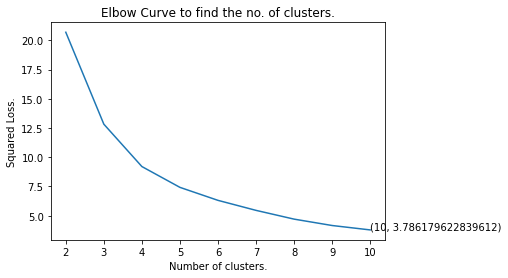

The optimal number of clusters obtained is -  10
The loss for optimal cluster is -  3.786179622839612


In [378]:
# Choosing the best cluster using Elbow Method.
# source credit,few parts of min squred loss info is taken from different parts of the stakoverflow answers.
# this is used to understand to find the optimal clusters in differen way rather than used in BOW, TFIDF
from sklearn.cluster import KMeans
squared_errors = []
for cluster in num_clus:
    kmeans = KMeans(n_clusters = cluster).fit(sent_vectors) # Train Cluster
    squared_errors.append(kmeans.inertia_) # Appending the squared loss obtained in the list
    
optimal_clusters = np.argmin(squared_errors) + 2 # As argmin return the index of minimum loss. 
plt.plot(num_clus, squared_errors)
plt.title("Elbow Curve to find the no. of clusters.")
plt.xlabel("Number of clusters.")
plt.ylabel("Squared Loss.")
xy = (optimal_clusters, min(squared_errors))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.show()

print ("The optimal number of clusters obtained is - ", optimal_clusters)
print ("The loss for optimal cluster is - ", min(squared_errors))

In [379]:
# Training the best model --
from sklearn.cluster import KMeans
model2 = KMeans(n_clusters = optimal_clusters)
model2.fit(sent_vectors)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [380]:
word_cluster_pred=model2.predict(sent_vectors)
word_cluster_pred_2=model2.labels_
word_cluster_center=model2.cluster_centers_

In [381]:
# Giving Labels/assigning a cluster to each point/text 
dfa = abstract
dfa['AVG-W2V Clus Label'] = model2.labels_
dfa.head(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,document,sentences,cleaned_sent,AVG-W2V Clus Label
0,doi: 10.1001/jamaneurol.2017.2814,Concordance Between Different Amyloid Immunoas...,concordance different amyloid immunoassays vis...,2
1,doi: 10.1001/jamaneurol.2017.4913,Association of Changes in Plasma Neurofilament...,association change plasma neurofilament light ...,4


In [382]:
dfa.groupby(['AVG-W2V Clus Label'])['sentences'].count()

AVG-W2V Clus Label
0    144
1    102
2    200
3     16
4    199
5     13
6     61
7    152
8     78
9     52
Name: sentences, dtype: int64

In [383]:
print("Top terms per cluster:")
for i in range(optimal_clusters):
    print("Cluster %d:" % i, end='')
    cl_data = dfa[dfa['AVG-W2V Clus Label']==i]
    fdist = FreqDist(word_tokenize(''.join(cl_data['cleaned_sent'])))
    print(' %s' % [x[0] for x in fdist.most_common(10)], end='')
    print()

Top terms per cluster:
Cluster 0: ['model', 'use', 'climate', 'change', 'study', 'data', 'result', 'global', 'different', 'increase']
Cluster 1: ['use', 'show', 'study', 'result', 'model', 'increase', 'change', 'large', 'demonstrate', 'highly']
Cluster 2: ['use', 'model', 'study', 'result', 'increase', 'show', 'change', 'data', 'effect', 'patients']
Cluster 3: ['liver', 'disease', 'csf', 'control', 'variants', 'study', 'iron', 'increase', 'change', 'proteins']
Cluster 4: ['model', 'use', 'study', 'result', 'patients', 'increase', 'show', 'change', 'data', 'find']
Cluster 5: ['noise', 'humidity', 'dragline', 'silk', 'molecules', 'use', 'chromatin', 'torsional', 'intermolecular', 'covalent']
Cluster 6: ['patients', 'disease', 'study', 'liver', 'fibrosis', 'p', 'csf', 'use', 'af', 'ms']
Cluster 7: ['use', 'study', 'result', 'model', 'show', 'patients', 'p', 'effect', 'data', '1']
Cluster 8: ['patients', 'disease', 'liver', 'p', 'fibrosis', 'associate', 'study', 'level', 'use', 'risk']
Clu

In [384]:
# Reading an abstract which belong to each group.
for i in range(optimal_clusters):
    print("An abstract of assigned to cluster ", i)
    print("-" * 50)
    print(dfa.iloc[dfa.groupby(['AVG-W2V Clus Label']).groups[i][0]]['sentences'])
    print('\n')
    print(dfa.iloc[dfa.groupby(['AVG-W2V Clus Label']).groups[i][1]]['sentences'])
    print('\n')
    print("_" * 50)

An abstract of assigned to cluster  0
--------------------------------------------------
Impacts of parameterized orographic drag on the
            N
            orthern
            H
            emisphere winter circulation Abstract A recent intercomparison exercise proposed by the Working Group for Numerical Experimentation (WGNE) revealed that the parameterized, or unresolved, surface stress in weather forecast models is highly model‐dependent, especially over orography. Models of comparable resolution differ over land by as much as 20% in zonal mean total subgrid surface stress (τtot). The way τtot is partitioned between the different parameterizations is also model‐dependent. In this study, we simulated in a particular model an increase in τtot comparable with the spread found in the WGNE intercomparison. This increase was simulated in two ways, namely by increasing independently the contributions to τtot of the turbulent orographic form drag scheme (TOFD) and of the orographic l

#### Document Embeddings from the Abstract, Project objective and  EU Call

In [385]:
#combine the abstract text with the project and eu call text
comb = pd.DataFrame(abstract['document'])
comb['full_text'] = ""
for i in range(0,len(abstract)):
  comb['full_text'][i] = abstract['cleaned_sent'][i] + df_proj['cleaned_prj'][i] + eu['cleaned_text'][i]
comb

,document,full_text
0,doi: 10.1001/jamaneurol.2017.2814,concordance different amyloid immunoassays vis...
1,doi: 10.1001/jamaneurol.2017.4913,association change plasma neurofilament light ...
2,doi: 10.1002/2015gl067056,dynamically trigger slip lead sustain fault go...
3,doi: 10.1002/2015ms000564,impact parameterized orographic drag n orthern...
4,doi: 10.1002/2016gl069551,climate model bias jet stream block storm trac...
...,...,...
1012,doi: 10.5194/tc-13-1325-2019,winter tourism climate change pyrenees french ...
1013,doi: 10.5194/tc-13-521-2019,timescales length scale arctic sea ice thickne...
1014,doi: 10.5506/aphyspolbsupp.9.603,real-time lattice simulation thermalization gl...
1015,doi: 10.7554/elife.15477,increase notch signal antagonize prc2-mediated...


In [386]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in comb['full_text'].values:
    list_of_sent.append(sent.split())

In [387]:
print(comb['full_text'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

concordance different amyloid immunoassays visual amyloid positron emission tomographic assessment importance visual assessment amyloid positron emission tomographic pet image approve regulatory authorities clinical use several immunoassays develop measure β-amyloid aβ 42 cerebrospinal fluid csf agreement csf aβ42 measure different immunoassays visual pet read may influence use csf biomarkers and/or amyloid pet assessment clinical practice trials objective determine concordance csf aβ42 level measure use 5 different immunoassays visual amyloid pet analysis design set participants study include 262 patients mild cognitive impairment subjective cognitive decline swedish biofinder biomarkers identify neurodegenerative disorder early reliably cohort recruit september 1 2010 december 31 2014 undergo flutemetamol f 18 18f flutemetamol –labeled pet level csf aβ42 analyze use classic innotest newer modify innotest fully automate lumipulse fl euroimmun ei meso scale discovery msd assay concentr

In [388]:
# Training the wor2vec model using train dataset
w2v_model=gensim.models.Word2Vec(list_of_sent,size=100, workers=4)

In [389]:
import numpy as np
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this train
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
sent_vectors = np.array(sent_vectors)
sent_vectors = np.nan_to_num(sent_vectors)
sent_vectors.shape

(1017, 100)

In [390]:
# Number of clusters to check.
num_clus = [x for x in range(3,16)]
num_clus

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

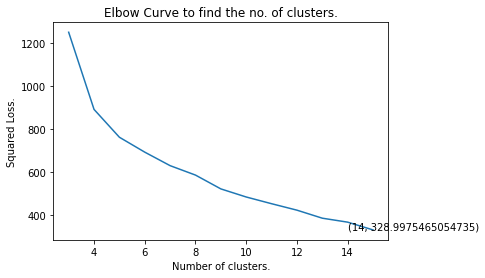

The optimal number of clusters obtained is -  14
The loss for optimal cluster is -  328.9975465054735


In [391]:
# Choosing the best cluster using Elbow Method.
# source credit,few parts of min squred loss info is taken from different parts of the stakoverflow answers.
# this is used to understand to find the optimal clusters in differen way rather than used in BOW, TFIDF
squared_errors = []
for cluster in num_clus:
    kmeans = KMeans(n_clusters = cluster).fit(sent_vectors) # Train Cluster
    squared_errors.append(kmeans.inertia_) # Appending the squared loss obtained in the list
    
optimal_clusters = np.argmin(squared_errors) + 2 # As argmin return the index of minimum loss. 
plt.plot(num_clus, squared_errors)
plt.title("Elbow Curve to find the no. of clusters.")
plt.xlabel("Number of clusters.")
plt.ylabel("Squared Loss.")
xy = (optimal_clusters, min(squared_errors))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.show()

print ("The optimal number of clusters obtained is - ", optimal_clusters)
print ("The loss for optimal cluster is - ", min(squared_errors))

In [392]:
# Training the best model --
from sklearn.cluster import KMeans
model2 = KMeans(n_clusters = optimal_clusters)
model2.fit(sent_vectors)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=14, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [393]:
word_cluster_pred=model2.predict(sent_vectors)
word_cluster_pred_2=model2.labels_
word_cluster_center=model2.cluster_centers_

In [394]:
dfa = comb
dfa['AVG-W2V Clus Label'] = model2.labels_
dfa.head(2)

,document,full_text,AVG-W2V Clus Label
0,doi: 10.1001/jamaneurol.2017.2814,concordance different amyloid immunoassays vis...,10
1,doi: 10.1001/jamaneurol.2017.4913,association change plasma neurofilament light ...,10


In [395]:
dfa.groupby(['AVG-W2V Clus Label'])['full_text'].count()

AVG-W2V Clus Label
0     155
1     150
2     128
3      38
4      17
5      61
6     126
7      59
8      39
9      49
10     48
11     34
12     38
13     75
Name: full_text, dtype: int64

In [397]:
print("Top terms per cluster:")
for i in range(optimal_clusters):
    print("Cluster %d:" % i, end='')
    cl_data = dfa[dfa['AVG-W2V Clus Label']==i]
    fdist = FreqDist(word_tokenize(''.join(cl_data['full_text'])))
    print(' %s' % [x[0] for x in fdist.most_common(10)], end='')
    print()

Top terms per cluster:
Cluster 0: ['health', 'diseases', 'million', 'age', 'cost', 'well-being', 'europe', 'include', 'people', 'increase']
Cluster 1: ['researchers', 'europe', 'new', 'science', 'research', 'base', 'state', 'many', 'model', 'scientific']
Cluster 2: ['climate', 'change', 'model', 'global', 'develop', 'impact', 'use', 'risk', 'focus', 'include']
Cluster 3: ['train', 'researchers', 'new', 'research', 'analytical', 'esrs', 'oxidative', 'modifications', 'tool', 'detect']
Cluster 4: ['image', 'mri', 'ulf', 'new', 'use', 'current', 'magnetic', 'measurements', 'meg', 'brain']
Cluster 5: ['train', 'researchers', 'research', 'br/', 'devices', 'new', 'optical', 'materials', 'switch', 'supramolecular']
Cluster 6: ['researchers', 'europe', 'research', 'br/', 'science', 'new', 'base', 'state', 'scientific', 'many']
Cluster 7: ['model', 'research', 'three', 'br/', 'partner', 'european', 'biomedicine', 'coe', 'infrastructures', 'use']
Cluster 8: ['research', 'mobility', 'researchers',

In [ ]:
# Reading an abstract which belong to each group.
for i in range(optimal_clusters):
    print("An abstract review of assigned to cluster ", i)
    print("-" * 70)
    print(dfa.iloc[dfa.groupby(['AVG-W2V Clus Label']).groups[i][0]]['full_text'])
    print('\n')
    print(dfa.iloc[dfa.groupby(['AVG-W2V Clus Label']).groups[i][1]]['full_text'])
    print('\n')
    print("_" * 70)

An abstract review of assigned to cluster  0
----------------------------------------------------------------------
preemptive‐tips improve outcome high‐risk variceal bleed observational study patients admit acute variceal bleed avb child-pugh c score cp-c child-pugh b plus active bleed endoscopy cp-b+ab high risk treatment failure rebleeding mortality preemptive transjugular intrahepatic portosystemic shunt p-tips show improve survival patients use clinical practice challenge routinely incorporate present study aim validate role preemptive tip large number high-risk patients multicenter international observational study include 671 patients 34 center admit avb high risk treatment failure patients manage accord current guidelines use drug endoscopic therapy d+e p-tips base individual center policy p-tips set avb associate lower mortality cp-c patients compare d+e 1 year mortality 22 vs. 47 d+e group p 0.002 mortality rate cp-b+ab patients low p-tips improve cp-c cp-b+ab patients p-tips